# Challenge 1 - A recommender system for online shops

## Project Introduction

This notebook is developed as part of the **Data Analytics and Artificial Intelligence** course at **Ca' Foscari University of Venice**.

student number : 909059

name and surname : Chiara Masi 

### Context
We are acting as a data scientist working for an online retail company. The objective is to build a **book recommender system** for an online marketplace, focused on the topic of **Machine Learning**.

The dataset used comes from [OpenLibrary.org](https://openlibrary.org) and contains **500 real books** retrieved using the keyword *"machine learning"*. Because the data is real and unfiltered, it requires careful **cleaning and preprocessing** before any recommendation logic can be applied.

### Recommendation Criteria
The recommender system ranks books based on three weighted criteria:

| Criterion | Description | Weight |
|-----------|-------------|--------|
| **Year of Publication** | More recent books are preferred (ML evolves fast) | High |
| **Number of Editions** | More editions suggest greater usefulness and popularity | Medium |
| **Python relevance** | Bonus if "python" appears in title, subjects, or description | Bonus |

This system is a simple content-based recommender. It does not take into account user reviews or purchasing behavior.

### Deliverables
- A cleaned dataset
- A scoring/ranking function
- Top-N recommendations (tested for **N = 3, 5, and 10**)

---

## 1. Import libraries

In [1]:
import pandas as pd 
import numpy as np
import re
import matplotlib.pyplot as plt  
import seaborn as sns

## 2. load dataset

In [2]:
df = pd.read_csv('Challenge 1 - data_ml_books_openlibrary.csv')
print(f"dataset shape: {df.shape}")
print(f"dataset columns : {list(df.columns)}")
df.head()

dataset shape: (500, 8)
dataset columns : ['title', 'authors', 'first_publish_year', 'edition_count', 'publishers', 'isbn', 'subjects', 'description']


,title,authors,first_publish_year,edition_count,publishers,isbn,subjects,description
0,Why Machines Learn,Anil Ananthaswamy,2024.0,4,NaN,NaN,Science,NaN
1,The Time Machine,H. G. Wells,1895.0,1146,NaN,NaN,"Self-experimentation in medicine in fiction, F...","The Time Traveller, a dreamer obsessed with tr..."
2,Machine learning,"Kevin P. Murphy, Kevin P. Murphy",2012.0,4,NaN,NaN,"Probabilities, Machine learning, Probability, ...","""This textbook offers a comprehensive and self..."
3,Introduction to Machine Learning with Python,"Andreas C. Mueller, Sarah Guido",2016.0,2,NaN,NaN,"Programming languages (Electronic computers), ...",NaN
4,Machine learning,Ethem Alpaydin,2016.0,4,NaN,NaN,"Artificial intelligence, Machine learning, Non...",A concise overview of machine learning -- comp...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               500 non-null    object 
 1   authors             495 non-null    object 
 2   first_publish_year  498 non-null    float64
 3   edition_count       500 non-null    int64  
 4   publishers          0 non-null      float64
 5   isbn                0 non-null      float64
 6   subjects            198 non-null    object 
 7   description         34 non-null     object 
dtypes: float64(3), int64(1), object(4)
memory usage: 31.4+ KB


In [4]:
print('Missing values:')
print(df.isnull().sum())

Missing values:
title                   0
authors                 5
first_publish_year      2
edition_count           0
publishers            500
isbn                  500
subjects              302
description           466
dtype: int64


## 3. Data Cleaning


In [5]:
# remove duplicate entries 

duplicate = df.duplicated()
print(f"rows duplicated {df[duplicate]}")
df = df.drop_duplicates()
df

rows duplicated                                            title  \
197                             Machine Learning   
490  Machine Learning con PyTorch y Scikit-Learn   

                                               authors  first_publish_year  \
197                Charles River Charles River Editors              2018.0   
490  Sebastian Raschka, Yuxi (Hayden) Liu, Vahid Mi...              2023.0   

     edition_count  publishers  isbn subjects description  
197              1         NaN   NaN      NaN         NaN  
490              1         NaN   NaN      NaN         NaN  


,title,authors,first_publish_year,edition_count,publishers,isbn,subjects,description
0,Why Machines Learn,Anil Ananthaswamy,2024.0,4,NaN,NaN,Science,NaN
1,The Time Machine,H. G. Wells,1895.0,1146,NaN,NaN,"Self-experimentation in medicine in fiction, F...","The Time Traveller, a dreamer obsessed with tr..."
2,Machine learning,"Kevin P. Murphy, Kevin P. Murphy",2012.0,4,NaN,NaN,"Probabilities, Machine learning, Probability, ...","""This textbook offers a comprehensive and self..."
3,Introduction to Machine Learning with Python,"Andreas C. Mueller, Sarah Guido",2016.0,2,NaN,NaN,"Programming languages (Electronic computers), ...",NaN
4,Machine learning,Ethem Alpaydin,2016.0,4,NaN,NaN,"Artificial intelligence, Machine learning, Non...",A concise overview of machine learning -- comp...
...,...,...,...,...,...,...,...,...
495,Handbook of Machine Learning,Tshilidzi Marwala,2018.0,1,NaN,NaN,"Machine learning, Artificial intelligence",NaN
496,Mathematics for Machine Learning,Prentiss Bussini,2020.0,1,NaN,NaN,NaN,NaN
497,Selected machine learning reductions,Anna Ewa Choromanska,2014.0,1,NaN,NaN,NaN,Machine learning is a field of science aiming ...
498,Machine Learning Part I,Bharathi S,2020.0,1,NaN,NaN,NaN,NaN


In [6]:
#we can drop columns publishers and isbn as seen they are not utile and have missing value 
df.describe()

,first_publish_year,edition_count,publishers,isbn
count,496.000000,498.000000,0.0,0.0
mean,2009.935484,16.313253,NaN,NaN
std,94.486020,176.679450,NaN,NaN
min,0.000000,0.000000,NaN,NaN
25%,2016.000000,1.000000,NaN,NaN
50%,2019.000000,1.000000,NaN,NaN
75%,2021.000000,3.000000,NaN,NaN
max,2025.000000,3546.000000,NaN,NaN


In [7]:
df = df.drop(columns=['publishers','isbn'])
df

,title,authors,first_publish_year,edition_count,subjects,description
0,Why Machines Learn,Anil Ananthaswamy,2024.0,4,Science,NaN
1,The Time Machine,H. G. Wells,1895.0,1146,"Self-experimentation in medicine in fiction, F...","The Time Traveller, a dreamer obsessed with tr..."
2,Machine learning,"Kevin P. Murphy, Kevin P. Murphy",2012.0,4,"Probabilities, Machine learning, Probability, ...","""This textbook offers a comprehensive and self..."
3,Introduction to Machine Learning with Python,"Andreas C. Mueller, Sarah Guido",2016.0,2,"Programming languages (Electronic computers), ...",NaN
4,Machine learning,Ethem Alpaydin,2016.0,4,"Artificial intelligence, Machine learning, Non...",A concise overview of machine learning -- comp...
...,...,...,...,...,...,...
495,Handbook of Machine Learning,Tshilidzi Marwala,2018.0,1,"Machine learning, Artificial intelligence",NaN
496,Mathematics for Machine Learning,Prentiss Bussini,2020.0,1,NaN,NaN
497,Selected machine learning reductions,Anna Ewa Choromanska,2014.0,1,NaN,Machine learning is a field of science aiming ...
498,Machine Learning Part I,Bharathi S,2020.0,1,NaN,NaN


In [8]:
# A simple heuristic: keep only titles that contain at least some ASCII letters
def is_likely_english(title):
    """Returns True if title contains mostly ASCII characters."""
    if not isinstance(title, str):
        return False
    ascii_ratio = sum(1 for c in title if ord(c) < 128) / len(title)
    return ascii_ratio > 0.80

df = df[df['title'].apply(is_likely_english)]
print(f'After filtering non-English titles: {len(df)} books')

After filtering non-English titles: 497 books


In [9]:
df = df.copy()
df['first_publish_year'] = pd.to_datetime(
    df['first_publish_year'], format='%Y', errors='coerce'
).dt.year.astype('Int64')
df

,title,authors,first_publish_year,edition_count,subjects,description
0,Why Machines Learn,Anil Ananthaswamy,2024,4,Science,NaN
1,The Time Machine,H. G. Wells,1895,1146,"Self-experimentation in medicine in fiction, F...","The Time Traveller, a dreamer obsessed with tr..."
2,Machine learning,"Kevin P. Murphy, Kevin P. Murphy",2012,4,"Probabilities, Machine learning, Probability, ...","""This textbook offers a comprehensive and self..."
3,Introduction to Machine Learning with Python,"Andreas C. Mueller, Sarah Guido",2016,2,"Programming languages (Electronic computers), ...",NaN
4,Machine learning,Ethem Alpaydin,2016,4,"Artificial intelligence, Machine learning, Non...",A concise overview of machine learning -- comp...
...,...,...,...,...,...,...
495,Handbook of Machine Learning,Tshilidzi Marwala,2018,1,"Machine learning, Artificial intelligence",NaN
496,Mathematics for Machine Learning,Prentiss Bussini,2020,1,NaN,NaN
497,Selected machine learning reductions,Anna Ewa Choromanska,2014,1,NaN,Machine learning is a field of science aiming ...
498,Machine Learning Part I,Bharathi S,2020,1,NaN,NaN


In [10]:
debut = df['first_publish_year'].min()
fin = df['first_publish_year'].max()

print(f"Period covered: from {debut} to {fin}")

Period covered: from 1865 to 2025


### Missing values and inconsistency

In [11]:
print(df[df['first_publish_year'].isnull()])

                             title                                authors  \
12               The Invisible Man                            H. G. Wells   
149               Machine Learning                        Thomas Mitchell   
303  Machine Learning using Python  Manaranjan Pradhan and U Dinesh Kumar   

     first_publish_year  edition_count  \
12                 <NA>            563   
149                <NA>              0   
303                <NA>              1   

                                              subjects  \
12   Ciencia-ficción, Classic Literature, Fiction, ...   
149                                                NaN   
303                                                NaN   

                                           description  
12   This book is the story of Griffin, a scientist...  
149                                                NaN  
303                                                NaN  


In [12]:
#Since the internet exists, I went and found the 3 missing pieces of data for the dates on the internet.
corrected= [
    {
        "title": "The Invisible Man",
        "authors": "H. G. Wells",
        "year": 1897
    },
    {
        "title": "Machine Learning",
        "authors": "Thomas Mitchell",
        "year": 1997
    },
    {
        "title": "Machine Learning using Python",
        "authors": "Manaranjan Pradhan and U Dinesh Kumar",
        "year": 2019
    }
]

for book in corrected:
    mask = (df['title'] == book['title']) & (df['authors'] == book['authors'])
    df.loc[mask, 'first_publish_year'] = book['year'] 


In [13]:
#columns author
print(df[df['authors'].isnull()])


                                title authors  first_publish_year  \
114                 Machine learning      NaN                1997   
128                  Machine learning     NaN                1986   
133                  Machine Learning     NaN                2010   
134                  Machine Learning     NaN                1990   
460  Fundamentals of Machine Learning     NaN                2018   

     edition_count                       subjects description  
114              1                            NaN         NaN  
128              1  Machine learning, Periodicals         NaN  
133              1                            NaN         NaN  
134              1            Science/Mathematics         NaN  
460              1                            NaN         NaN  


Since it is difficult to find the exact author of these books with a very common title and only one year of publication, the simplest thing is to delete them.

In [14]:
df = df.dropna(subset=['authors'])
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   title               492 non-null    object
 1   authors             492 non-null    object
 2   first_publish_year  492 non-null    Int64 
 3   edition_count       492 non-null    int64 
 4   subjects            195 non-null    object
 5   description         33 non-null     object
dtypes: Int64(1), int64(1), object(4)
memory usage: 23.7+ KB


In [15]:
df[df['edition_count']== 0]
df['edition_count'] = df['edition_count'].replace(0, 1)
df.describe()

,first_publish_year,edition_count
count,492.0,492.000000
mean,2014.908537,14.300813
std,15.891619,171.081474
min,1865.0,1.000000
25%,2016.0,1.000000
50%,2019.0,1.000000
75%,2021.0,3.000000
max,2025.0,3546.000000


### Extraction of relevant works (ML keywords)

In [16]:
# Filter to relevant ML books
# Keep books whose title OR subjects mention ML-related keywords

ML_KEYWORDS = [
    'machine learning', 'deep learning', 'neural network', 'artificial intelligence',
    'data science', 'data mining', 'natural language processing', 'computer vision',
    'reinforcement learning', 'statistics', 'python', 'scikit', 'tensorflow',
    'pytorch', 'nlp', 'ai', 'ml'
]
def is_ml_relevant(row):
    text = ' '.join([
        str(row.get('title', '')),
        str(row.get('subjects', '')),
        str(row.get('description', ''))
    ]).lower()
    
    for kw in ML_KEYWORDS:
        if len(kw) <= 3:
            if re.search(rf'\b{re.escape(kw)}\b', text):
                return True
        else:
            if kw in text:
                return True
    return False

df = df[df.apply(is_ml_relevant, axis=1)]

print(f'After ML relevance filtering: {len(df)} books')

After ML relevance filtering: 480 books


### Exploratory Data Analysis

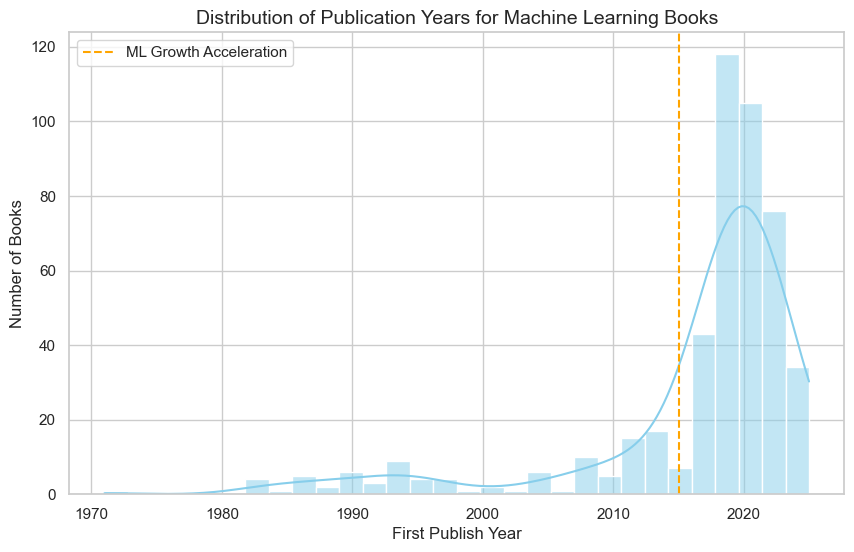

Median Publication Year: 2019.0
Oldest Book: 1971
Newest Book: 2025


In [17]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.histplot(df['first_publish_year'].dropna(), bins=30, kde=True, color='skyblue')

plt.axvline(2015, color='orange', linestyle='--', label='ML Growth Acceleration')

plt.title('Distribution of Publication Years for Machine Learning Books', fontsize=14)
plt.xlabel('First Publish Year', fontsize=12)
plt.ylabel('Number of Books', fontsize=12)
plt.legend()
plt.show()

median_year = df['first_publish_year'].median()
print(f"Median Publication Year: {median_year}")
print(f"Oldest Book: {df['first_publish_year'].min()}")
print(f"Newest Book: {df['first_publish_year'].max()}")

## 4. Scoring & Ranking Function

Since as the domain of machine learning is evolving fast, therefore the books published in
recent years can be assigned higher scores. The second important factor is the number of
editions, which can be a good indicator of usefulness. Furthermore, the user would like to read
about the machine learning techniques and employ such models in “python”. Therefore,
including “python” in the book “title” or “subjects” or “description” can be a better option.

Each book receives a **composite score** computed as follows:

$$\text{score} = w_1 \cdot \text{year\_score} + w_2 \cdot \text{edition\_score} + w_3 \cdot \text{python\_bonus}$$

Where:
- **year_score**: Min-max normalized publication year: books published in recent years get higher scores.
- **edition_score**: Log-normalized edition count: diminishing returns for very high edition counts (e.g. classics like *The Time Machine* should not dominate).
- **python_bonus**: Binary flag (0 or 1) if "python" appears in title, subjects, or description.
- **Weights**: $w_1 = 0.50$, $w_2 = 0.30$, $w_3 = 0.20$

In [18]:
def compute_scores(df, w_year=0.50, w_edition=0.30, w_python=0.20):
    """
    Computes a composite recommendation score for each book.
    
    args :
    df        : pd.DataFrame — cleaned book dataset
    w_year    : float — weight for publication year score
    w_edition : float — weight for edition count score
    w_python  : float — weight for Python relevance bonus
    
    Returns: df with an added 'score' column, sorted descending.
    """
    df = df.copy()

    # Year score: min-max normalization
    year_min, year_max = df['first_publish_year'].min(), df['first_publish_year'].max()
    df['year_score'] = (df['first_publish_year'] - year_min) / (year_max - year_min + 1e-9)

    # Edition score: log normalization
    df['edition_score'] = np.log1p(df['edition_count']) / np.log1p(df['edition_count'].max())

    # Python bonus: 1 if 'python' found anywhere in the book metadata
    def has_python(row):
        text = ' '.join([
            str(row['title']),
            str(row['subjects']),
            str(row['description'])
        ]).lower()
        return 1 if 'python' in text else 0

    df['python_bonus'] = df.apply(has_python, axis=1)

    df['score'] = (
        w_year    * df['year_score'] +
        w_edition * df['edition_score'] +
        w_python  * df['python_bonus']
    )

    return df.sort_values(
        by=['score', 'edition_count', 'title'], 
        ascending=[False, False, True]
    ).reset_index(drop=True)

## 5. Recommender System Function

In [19]:
def recommend_books(df, n=5):
    """
    Returns the top-N recommended Machine Learning books.

    args:
    df : pd.DataFrame — pre-scored dataframe (output of compute_scores)
    n  : int — number of recommendations to return

    Returns : df : top N books with key columns
    """
    top_n = df.head(n)[['title', 'authors', 'first_publish_year', 'edition_count', 'python_bonus', 'score']].copy()
    top_n.index = range(1, n + 1)
    top_n.index.name = 'Rank'
    top_n.columns = ['Title', 'Authors', 'Year', 'Editions', 'Python-related', 'Score']
    top_n['Score'] = top_n['Score'].round(4)
    return top_n

In [20]:
df_scored = compute_scores(df)

# Show score breakdown for top books
cols_show = ['title', 'authors', 'first_publish_year', 'edition_count',
             'year_score', 'edition_score', 'python_bonus', 'score']
df_scored[cols_show].head(15)

,title,authors,first_publish_year,edition_count,year_score,edition_score,python_bonus,score
0,Machine Learning Engineering with Python,Andrew P. McMahon,2021,4,0.925926,0.627474,1,0.851205
1,Machine Learning with Python,Charles Countess,2021,4,0.925926,0.627474,1,0.851205
2,Machine Learning with Python,Tarkeshwar Barua,2022,3,0.944444,0.540476,1,0.834365
3,Machine Learning with Python,Parteek Bhatia,2022,3,0.944444,0.540476,1,0.834365
4,"Hands-On Machine Learning with Scikit-Learn, K...",Aurélien Géron,2019,4,0.888889,0.627474,1,0.832687
5,Python Machine Learning,Ryan Turner,2019,4,0.888889,0.627474,1,0.832687
6,Machine Learning with Python,Amin Zollanvari,2023,2,0.962963,0.428317,1,0.809977
7,Machine Learning with Python,Paige Jacobs,2019,3,0.888889,0.540476,1,0.806587
8,Python Machine Learning,Wei-Meng Lee,2019,3,0.888889,0.540476,1,0.806587
9,Python Machine Learning,Andrew Park,2019,3,0.888889,0.540476,1,0.806587


## 6. Results — Top 3, 5, and 10 Recommendations

In [21]:
print('=' * 70)
print('TOP 3 RECOMMENDED MACHINE LEARNING BOOKS')
print('=' * 70)
print(recommend_books(df_scored, n=3))

TOP 3 RECOMMENDED MACHINE LEARNING BOOKS
                                         Title            Authors  Year  \
Rank                                                                      
1     Machine Learning Engineering with Python  Andrew P. McMahon  2021   
2                 Machine Learning with Python   Charles Countess  2021   
3                 Machine Learning with Python   Tarkeshwar Barua  2022   

      Editions  Python-related   Score  
Rank                                    
1            4               1  0.8512  
2            4               1  0.8512  
3            3               1  0.8344  


In [22]:
print('=' * 70)
print('TOP 5 RECOMMENDED MACHINE LEARNING BOOKS')
print('=' * 70)
print(recommend_books(df_scored, n=5))

TOP 5 RECOMMENDED MACHINE LEARNING BOOKS
                                                  Title            Authors  \
Rank                                                                         
1              Machine Learning Engineering with Python  Andrew P. McMahon   
2                          Machine Learning with Python   Charles Countess   
3                          Machine Learning with Python   Tarkeshwar Barua   
4                          Machine Learning with Python     Parteek Bhatia   
5     Hands-On Machine Learning with Scikit-Learn, K...     Aurélien Géron   

      Year  Editions  Python-related   Score  
Rank                                          
1     2021         4               1  0.8512  
2     2021         4               1  0.8512  
3     2022         3               1  0.8344  
4     2022         3               1  0.8344  
5     2019         4               1  0.8327  


In [23]:
print('=' * 70)
print('TOP 10 RECOMMENDED MACHINE LEARNING BOOKS')
print('=' * 70)
print(recommend_books(df_scored, n=10))

TOP 10 RECOMMENDED MACHINE LEARNING BOOKS
                                                  Title            Authors  \
Rank                                                                         
1              Machine Learning Engineering with Python  Andrew P. McMahon   
2                          Machine Learning with Python   Charles Countess   
3                          Machine Learning with Python   Tarkeshwar Barua   
4                          Machine Learning with Python     Parteek Bhatia   
5     Hands-On Machine Learning with Scikit-Learn, K...     Aurélien Géron   
6                               Python Machine Learning        Ryan Turner   
7                          Machine Learning with Python    Amin Zollanvari   
8                          Machine Learning with Python       Paige Jacobs   
9                               Python Machine Learning       Wei-Meng Lee   
10                              Python Machine Learning        Andrew Park   

      Year  Editions 

## 7. Conclusion
This project transformed a raw dataset from OpenLibrary into a functional decision support tool. The main challenge lay in the heterogeneity of the data: it was necessary to address missing values, eliminate irrelevant works (such as fiction classics), and normalize variables of varying scales.

The final recommendation system meets business requirements by prioritizing:

Technological relevance (50% weighting based on the year of publication).

Market validation (30% weighting based on the number of editions).

Compatibility with industry tools (20% bonus for the Python ecosystem).

Tests performed for N=3, 5, and 10 show consistency in the results, suggesting modern reference works such as "Machine Learning Engineering with Python." To further refine the system, integrating additional popularity metrics (user ratings or number of citations) could improve the accuracy of the recommendations.